In [1]:
# dodawanie Google Drive'a (praca na Google Colab)

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [44]:
# import bibliotek

import pandas as pd
import numpy as np
import seaborn as sns
import os
import glob
import cv2
import matplotlib.pyplot as plt

from sklearn.utils import shuffle


In [14]:
# funkcja do pobierania zdjęć z folderu

def load_from_folder(folder, only_path = False, label = ""):
    if only_path == False:
        images = []
        for filename in os.listdir(folder):
            img = plt.imread(os.path.join(folder,filename))
            if img is not None:
                images.append(img)
        return images
    else:
        path = []
        for filename in os.listdir(folder):
            img_path = os.path.join(folder,filename)
            if img_path is not None:
                path.append([label,img_path])
        return path

In [9]:
# lista folderów, w których są zdjecia na drivie

files = glob.glob(f"/content/drive/My Drive/Fruits/*")
for file_path in files:  
  print(file_path)

/content/drive/My Drive/Fruits/Banana
/content/drive/My Drive/Fruits/Mango
/content/drive/My Drive/Fruits/Pear
/content/drive/My Drive/Fruits/Orange
/content/drive/My Drive/Fruits/Apple


In [39]:
# ładowanie zdjęć i ścieżek (wymagana cierpliwość, bo chwilę to trwa)

images = []

for file_path in files:
    if "png" in os.listdir(file_path)[0]:
        images += load_from_folder(file_path,True,label = file_path.split("/")[-1])

In [40]:
# tworzenie df ze ścieżkami i etykietami dla każdego owocu

df = pd.DataFrame(images, columns = ["fruit", "path"])

In [42]:
# mieszanie datasetu
df = shuffle(df, random_state = 0)
df = df.reset_index(drop=True)

# Przypisanie każdemu owocowi etykiety z numerem
fruit_names = sorted(df.fruit.unique())
mapper_fruit_names = dict(zip(fruit_names, [t for t in range(len(fruit_names))]))
df["label"] = df["fruit"].map(mapper_fruit_names)
print(mapper_fruit_names)

{'Apple': 0, 'Banana': 1, 'Mango': 2, 'Orange': 3, 'Pear': 4}


In [43]:
df.head()

,fruit,path,label
0,Pear,/content/drive/My Drive/Fruits/Pear/Pear 276.png,4
1,Apple,/content/drive/My Drive/Fruits/Apple/Apple 022...,0
2,Banana,/content/drive/My Drive/Fruits/Banana/Banana03...,1
3,Apple,/content/drive/My Drive/Fruits/Apple/Apple 018...,0
4,Banana,/content/drive/My Drive/Fruits/Banana/Banana06...,1


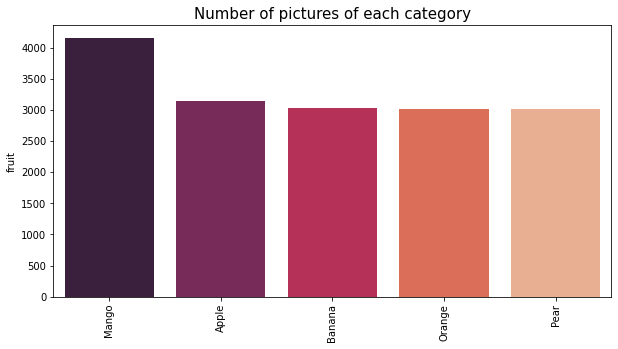

In [45]:
# prezentacja liczności poszczególnych klas

value_cnt = df["fruit"].value_counts()
plt.figure(figsize=(10,5))
sns.barplot(x = value_cnt.index, y = value_cnt, palette = "rocket")
plt.title("Number of pictures of each category", fontsize = 15)
plt.xticks(rotation=90)
plt.show()